In [1]:
from pyscipopt import Model, quicksum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import yfinance as yf
import solve as sl
import data_handling as dh
pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

### 人的資本を考慮したシミュレーション型多期間ポートフォリオ最適化

従来の資産配分問題では、金融資産への投資のみをモデル化していた。

しかし、私たちが実際にお金の使い道を考えるとき、自分への投資（＝人的資本への投資）も考慮して資産配分を決定している。

本プロジェクトでは、人的資本を考慮した資産配分問題をモデル化することで、以下のような問いに回答を与えることを目的とする。

1. スキルや経験の違いによって、人的資本への投資比率はどのように変わるべきか？ 
2. 高齢者のリスキリングには意味があるのか？
3. スキルがない人は、人的資本には投資せず、稼いだお金を金融資産に投資をするべきか？


・外生変数

$T$ : 期間

$I$ : パス数（シミュレーション回数）

$\delta$ : 売買コスト

$r^{(i)}_t$ : $t$ 期のパス $i$ の無リスク金利

$\rho^{(i)}_{j,t}$ : $t$ 期のパス $i$ の危険資産 $j$ の価格

$W_0$ : 初期富

$W_E$ : 期待富（全パスの平均的な富がどの水準に達していたいか）

$W_G$ : 目標富（全パスが最低限どの水準に達していたいか）

$H_0$ : その人が時間によらず保持する人的資本ストック（単位：金額）

$\tau_1, ..., \tau_k, ... \tau_7$ : 8段階あるスキルの閾値（人的資本への投資額がどの値まで達すれば上の（下の）スキル段階になるか）

$\beta_1, ..., \beta_k, ..., \beta_8 $ : スキル段階に応じたリターン（金額）

$d_1, ..., d_m $ : $m$ 期前までの人的資本への投資に対する減衰係数

・内生変数

$v^{(i)}_{t}$ : $t$ 期の無リスク資産への投資額（金額）

$z_{jt}$ : $t$ 期の危険資産 $j$ の投資量（単元）

$P^+_{jt}$ : $t$ 期の危険資産 $j$ の購入量（単元）

$P^-_{jt}$ : $t$ 期の危険資産 $j$ の売却量（単元）

$q^{(i)}$ : 最終期でのパス $i$ の富の目標富に対する不足分

$h^{(i)}_t$ : 人的資本への投資額（金額、フロー）

$H^{(i)}_t$ : 人的資本のストック（金額）

$u^{(i)}_{t,k}$ : $t$ 期・パス $i$ のスキル段階を示す変数（ $H^{(i)}_t$ と閾値 $\tau_k$ の値に応じて、該当するスキル段階 $k$ で1, 他で0を取る変数）

$y^{(i)}_t$ : 人的資本から生み出される賃金（金額）

$$
\begin{align*}
  &\text{Minimize} \quad  \frac{1}{I} \sum_{i=1}^I q^{(i)} \\[5mm]
  &\text{subject to} \\
  &\quad \sum_{j=1}^n (1+\delta) \rho_{j0} z_{j0} + v_0 + h_0 \;=\; W_0 \\[5mm]
  &\quad z_{jt} = z_{j, t-1} + P_{jt}^{+} - P_{jt}^{-}\\[5mm]
  &\quad \sum_{j=1}^n (1+\delta) \rho^{(i)}_{j1} P_{j1}^{+} + v^{(i)}_1 + h^{(i)}_1 \;=\; 
  \sum_{j=1}^n (1-\delta) \rho^{(i)}_{j1} P_{j1}^{-} + (1+r_0)v^{(i)}_0 + y_1 \\[5mm]
  &\quad \sum_{j=1}^n (1+\delta) \rho^{(i)}_{jt} P_{jt}^{+} + v^{(i)}_t + h^{(i)}_t \;=\; 
  \sum_{j=1}^n (1-\delta) \rho^{(i)}_{jt} P_{jt}^{-} + (1+r^{(i)}_{t-1})v^{(i)}_{t-1} + y^{(i)}_{t} \\[5mm]
  &\quad \sum_{j=1}^n (1-\delta) \bar{\rho}_{jT} z_{j,T-1} + \frac{1}{I} \sum_{i=1}^I \left\{ (1+r^{(i)}_{T-1})v^{(i)}_{T-1} + y^{(i)}_T \right\} \; \ge \; W_E \\[5mm]
  &\quad \sum_{j=1}^n (1-\delta) \rho^{(i)}_{jT} z_{j,T-1} + (1+r^{(i)}_{T-1})v^{(i)}_{T-1} + y^{(i)}_T  + q^{(i)}  \ge \; W_G\\[5mm]
  &\quad H^{(i)}_t = H_0 + d_1h^{(i)}_{t-1} + d_2h^{(i)}_{t-2} + ... + d_m h^{(i)}_{t-m}  \quad \text{（AR(m)モデルを意識）}\\[5mm]
  &\quad y^{(i)}_t = \beta_{s_1} u^{(i)}_{t,1} + \beta_{s_2} u^{(i)}_{t,2} + ... + \beta_{s_8} u^{(i)}_{t,8} \\[5mm]

  &\quad u^{(i)}_{t,s_k} \in \{0,1\} \\[5mm]
  &\quad \sum_{k=1}^{8} u^{(i)}_{t,k} = 1 \\[5mm]
  &\quad H^{(i)}_t > \tau_{k-1} - M(1-u^{(i)}_{t,k-1}) \\[5mm]
  &\quad H^{(i)}_t < \tau_{k} + M(1-u^{(i)}_{t,k}) \\[5mm]
  &\quad M \ge 0 \quad \text{十分大きな数} \\[5mm]
  &\quad z_{jt} \ge 0 \\[5mm]
  &\quad P_{jt}^{+} \ge 0 \\[5mm]
  &\quad P_{jt}^{-} \ge 0 \\[5mm]
  &\quad v^{(i)}_{t} \ge 0 \\[5mm]
  &\quad q^{(i)} \ge 0 \\[5mm]
  &\quad h^{(i)}_{t} \ge 0 \\[5mm]


\end{align*}
$$

In [3]:
mapping = {
    "先進国株（米国中心）":     "ACWI",
    #"グロース日本株":          "JPXN",     # （厳密なグロースでなくてOKならこれで）
    #"成熟外国株":              "VEA",
    #"成熟日本株":              "EWJ",
    "先進国高格付債":          "LQD",
    #"国内高格付債":            "2510.T",
    #"海外ジャンク債":          "HYG",
    #"国内ジャンク債":          None,       # → HYG で代用（下で処理）
    #"ブロード商品指数":        "DBC",
    #"海外REIT":                "VNQ",
    #"国内REIT":                "1343.T",
    #"海外保険（主に生命保険）":"KIE",
    #"国内保険（主に生命保険）":"1628.T",
    # クリプトETF（BTC/ETH） → 合成
    # 国内住居用不動産 → 未実装（指標ご指定ください）
    # 国内収益不動産 → 1343.T を 1.2x（リターン拡大）で合成
    # 円現金/定期預金 → 年0.1%
    # ドル現金/定期預金 → 年3%
}

exval_std_df, corr_df, asset_names = dh.data_download(mapping=mapping,
                                                      include_dom_hy=False,
                                                      include_usd_cash=False,
                                                      include_dom_income_re=False, 
                                                      include_crypto50=True,
                                                      T=5) #期間を変える場合、ここを変える
risk_assets = asset_names[1:]
rf_asset = asset_names[0]

In [4]:
n = len(asset_names)
T = exval_std_df.columns.get_level_values("期間").max()

### モデルを動かす際の注意点

1. 資産の数が少なすぎるとダメ 
2. ベータが極端に高い・低いとダメ
3. 目標富・期待富が高すぎるとダメ
4. 上手くいっている時は計算時間が短い
5. 計算時間制限は最大60秒とし、時間内に解けない場合はエラーを吐きます

上記のパラメータの感応度が高すぎる？

例）他の条件が一緒で $W_E$ を 1,400から1,500に変えると資産投資比率が大きく変わる

### 気になる挙動

1. $W_E$ が170 × $T$ あたりで、現金比率が90%を超える
2. $W_G$ を小さくすると、現金比率が高くなる
3. $d$ が小さいほど、初期の人的資本への投資が大きくなる（しかし、0.4あたりでまた減少する）
4. $m$ が小さいほど、現金比率が高くなる
5. （恐らく$T-1$ 期で既に目標富 $W_E$ を達成していると）最終期に株式投資に大きく投資する場合がある
6. スキルと賃金の関係がU字型でも $h_0$ が高くなる場合がある
7. 0期目に人的資本へ大きく投資 → 1期目にMAXの賃金 → $tau$ は固定のため、投資割合が少なくても最高レベルのスキルが保てる

### シミュレーションするケース

1. 大卒、年収500万円、1年経つと60%減耗、貯金100万円、10年後にはできれば5000万円にしたいが、最低でも3000万円にしたい

→ 若い時に人的資本に投資＋リスク資産に投資、その後は安定資産に投資を増やす

2. 上記と同じ設定、しかし、1年経つと80%減耗、かつスキルと賃金の関係がU字型

→ 人的資本への投資はほぼ0に抑えて、金融資産へバランスよく分散投資するべき

In [5]:

#######################################
#外生変数

#富（変更可）
W_0 = 100.0
W_E = 20_000.0 
W_G = 8_000.0 

#取引コスト（変更可）
delta = 0.0 

#人的資本パラメータ（基本変更しない）
tau_skills = 7

#人的資本パラメータ（変更可）

#初期の人的資本ストック
H_0 = 200.0
#過去何年の人的資本投資までがストックに入るか
m = 5
#スキルに応じた賃金
beta = np.array([400.0, 600.0, 800.0, 1000.0, 1200.0, 2000.0, 5000.0, 10_000.0 ])
#減耗の係数
depreciation = np.array([0.8**t for t in range(1,m+1)])
#スキルの閾値
thresholds = H_0 + W_0 * 0.15 * (1 + np.arange(tau_skills))

#資産のパラメータ（基本変更しない）
initial_call_rate = 0.000083
initial_asset_price = 1.0

##########################################

In [6]:
beta

array([  400.,   600.,   800.,  1000.,  1200.,  2000.,  5000., 10000.])

In [7]:
H_min, H_max, M_t = sl.compute_bounds_and_M(T, H_0, depreciation, h_cap=W_0)
H_max

{1: 280.0, 2: 344.0, 3: 395.20000000000005, 4: 436.16, 5: 468.92800000000005}

In [8]:
thresholds

array([215., 230., 245., 260., 275., 290., 305.])

In [9]:
depreciation

array([0.8    , 0.64   , 0.512  , 0.4096 , 0.32768])

In [10]:
beta

array([  400.,   600.,   800.,  1000.,  1200.,  2000.,  5000., 10000.])

In [11]:
exval_std_df

資産名  円現金/定期預金（年0.1%）                                                  \
期間                 1         2         3             4             5   
統計量                                                                    
期待値     8.318817e-05  0.000083  0.000083  8.302044e-05  8.327723e-05   
標準偏差    8.679874e-07  0.000001  0.000001  5.426573e-07  7.159237e-07   

資産名  先進国株（米国中心）                                           先進国高格付債            \
期間            1         2         3         4         5         1         2   
統計量                                                                           
期待値    0.004586  0.013943 -0.000388  0.015848  0.014941  0.004676  0.007344   
標準偏差   0.043306  0.058026  0.043585  0.050903  0.028099  0.016691  0.025614   

資産名                                クリプトETF（BTC/ETH 50/50）                      \
期間           3         4         5                      1         2         3   
統計量                                                                             
期待値  -0.008936  0.003856  0.004980               0.036888  0.103361  0.022065   
標準偏差  0.026861  0.037304  0.018427               0.294617  0.250097  0.237400   

資産名                       
期間           4         5  
統計量                       
期待値   0.068116  0.027664  
標準偏差  0.155055  0.166024

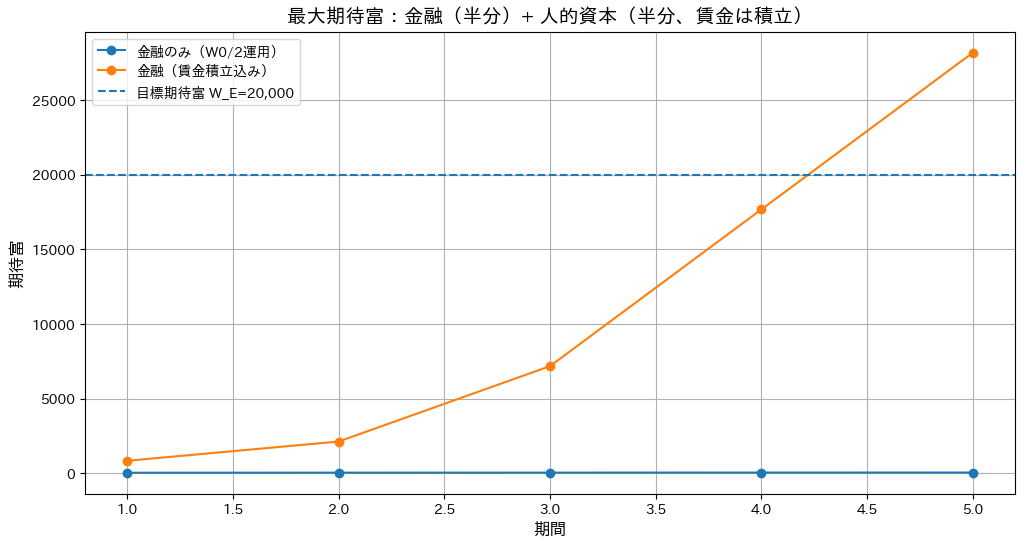

最終期の 金融のみ（W0/2）: 64.1752
最終期の 合計期待富:        28,165.6709


,最大期待値（金融）,賃金（期ごと）,金融のみ（W0/2運用）,金融（賃金積立込み）,合計期待富（金融+賃金積立）
期間,,,,,
1,0.036888,800.0,51.844385,851.844385,851.844385
2,0.103361,1200.0,57.203076,2139.891929,2139.891929
3,0.022065,5000.0,58.465254,7187.108367,7187.108367
4,0.068116,10000.0,62.447655,17676.663172,17676.663172
5,0.027664,10000.0,64.175209,28165.670899,28165.670899


In [12]:
sl.max_exp_wealth_with_hc_reinvest(
    exval_std_df, W_0, W_E,
    thresholds, beta, H_0, depreciation, T,
    h_cap=None,                 # 人的資本に回す毎期の投資上限（既定: W0/2）
    reinvest_rate=1.0,          # 毎期の賃金をどの割合で金融資産に積立するか（0~1）
    title="最大期待富：金融（半分）+ 人的資本（半分、賃金は積立）"
)

In [13]:
simulated = dh.get_simulated_rets(exval_std_df, corr_df, n_paths=100)
gross_rets_df = dh.get_gross_rets(simulated, asset_names)
r_df, rho_df = dh.get_r_rho_df(gross_rets_df, asset_names)

In [14]:
I = simulated.index.get_level_values("パス").max()
variables_columns = simulated.columns
JJ = range(1, n+1)
TT = range(T)               # decision times 0..T-1
TT_tr = range(1, T)         # trade times 1..T-1
II = range(I)

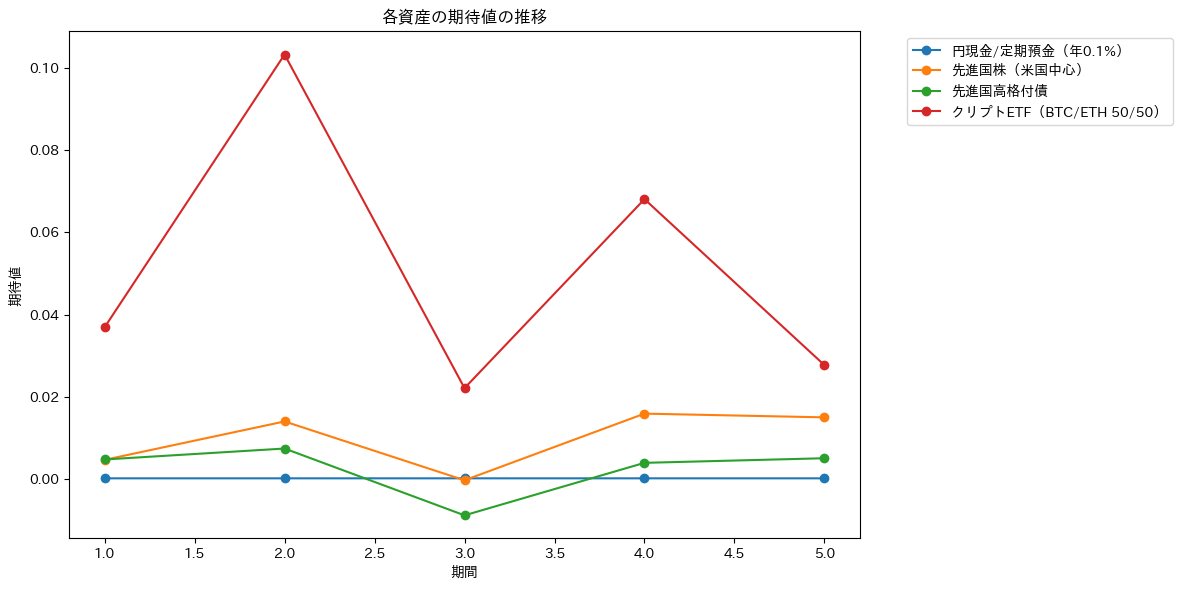

In [15]:
plt.figure(figsize=(12,6))

# unique asset list from the column MultiIndex
assets = exval_std_df.columns.get_level_values("資産名").unique()

for a in assets:
    # Get a 1-D Series indexed by 期間
    y = exval_std_df.loc["期待値"].xs(a, level="資産名", axis=1)
    # Ensure 1-D numpy array
    y_vals = y.to_numpy().ravel()
    x_vals = np.array([t for t in range(1,T+1)]) # the periods

    plt.plot(x_vals, y_vals, marker="o", label=a)

plt.title("各資産の期待値の推移")
plt.xlabel("期間")
plt.ylabel("期待値")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

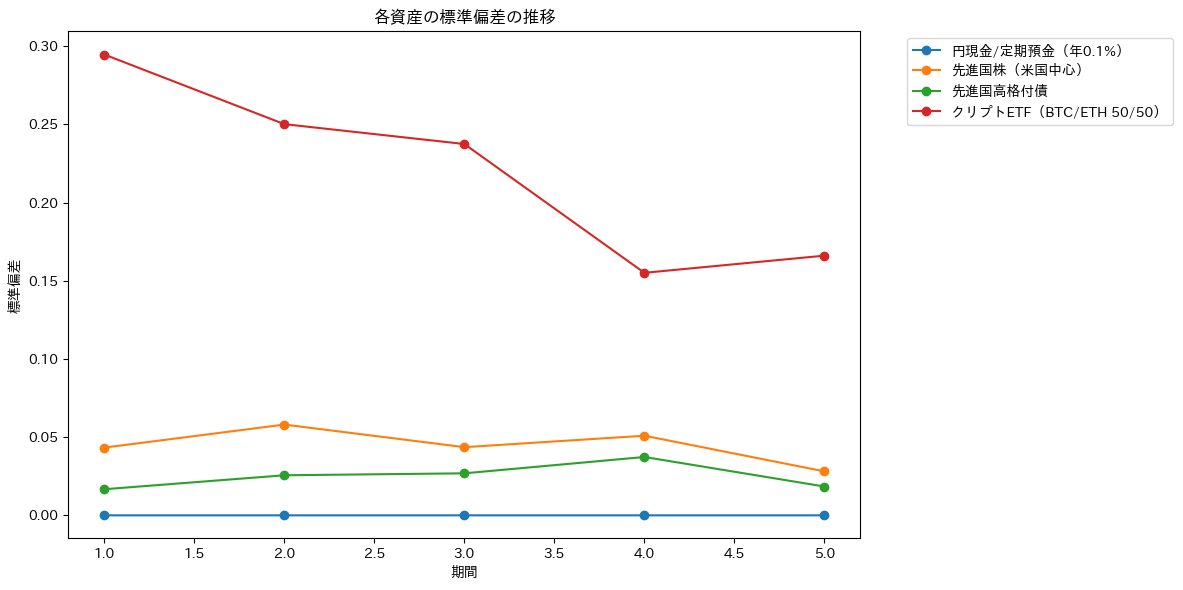

In [16]:
plt.figure(figsize=(12,6))

for a in assets:
    # Get a 1-D Series indexed by 期間
    y1 = exval_std_df.loc["標準偏差"].xs(a, level="資産名", axis=1)
    # Ensure 1-D numpy array
    y1_vals = y1.to_numpy().ravel()

    plt.plot(x_vals, y1_vals, marker="o", label=a)

plt.title("各資産の標準偏差の推移")
plt.xlabel("期間")
plt.ylabel("標準偏差")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

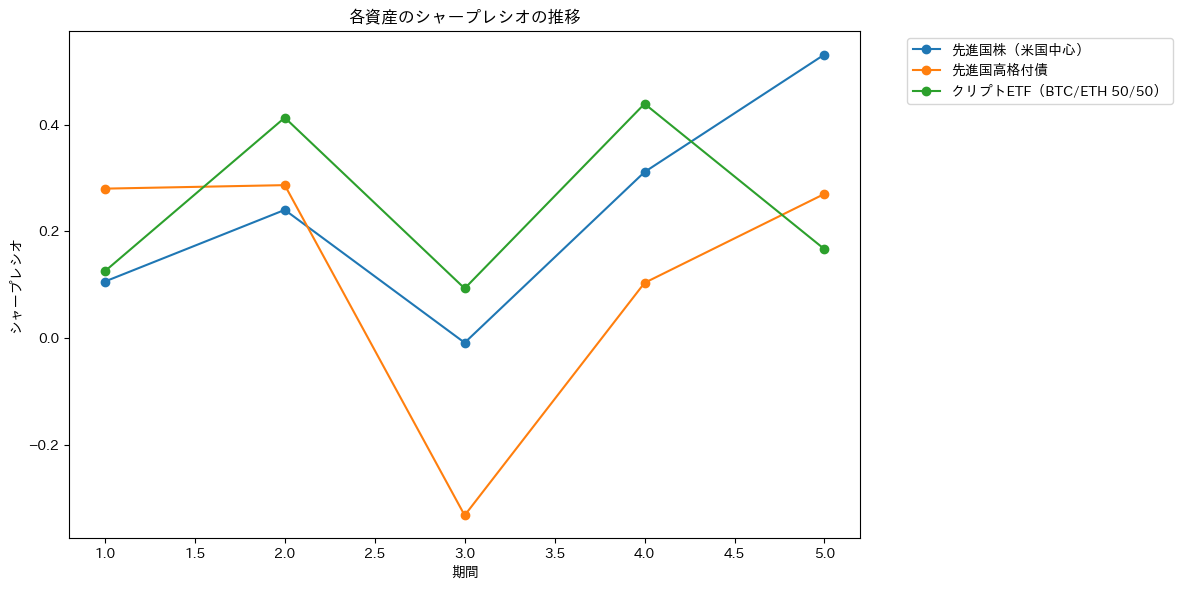

In [17]:
plt.figure(figsize=(12,6))

for a in assets:
    if not a == rf_asset:
        # Get a 1-D Series indexed by 期間
        y = exval_std_df.loc["期待値"].xs(a, level="資産名", axis=1)
        # Ensure 1-D numpy array
        y_vals = y.to_numpy().ravel()

        y1 = exval_std_df.loc["標準偏差"].xs(a, level="資産名", axis=1)
        # Ensure 1-D numpy array
        y1_vals = y1.to_numpy().ravel()

        plt.plot(x_vals, y_vals/y1_vals, marker="o", label=a)
    else:
        pass

plt.title("各資産のシャープレシオの推移")
plt.xlabel("期間")
plt.ylabel("シャープレシオ")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [18]:
# Get the last period value
last_period = rho_df.columns.get_level_values("期間").max()
# Select columns for the last period
rho_last = rho_df.xs(last_period, axis=1, level="期間")
# Calculate the mean across all paths (rows) for each asset
rho_bar_T = rho_last.mean(axis=0)
rho_bar_T_df = pd.DataFrame(rho_bar_T, columns=["rho_bar_T"]).T
ave_asset_price_df = pd.DataFrame(rho_df.mean(), columns=["平均資産価格"]).T

In [19]:
rho_df

資産名 円現金/定期預金（年0.1%）                                                    \
期間                0         1         2         3         4         5   
パス                                                                      
1          0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
2          0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
3          0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
4          0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
5          0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
..              ...       ...       ...       ...       ...       ...   
96         0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
97         0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
98         0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
99         0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   
100        0.000083  0.000083  0.000083  0.000083  0.000083  0.000083   

資産名 先進国株（米国中心）                                                   先進国高格付債  \
期間           0         1         2         3         4         5       0   
パス                                                                         
1          1.0  1.061748  1.079666  1.029909  1.062041  1.107235     1.0   
2          1.0  0.960575  0.955600  0.910168  0.921057  0.896962     1.0   
3          1.0  1.010149  0.969164  0.966638  0.962948  0.956589     1.0   
4          1.0  1.060650  1.088899  1.102599  1.159776  1.220067     1.0   
5          1.0  1.037661  1.032723  1.040282  1.056044  1.092620     1.0   
..         ...       ...       ...       ...       ...       ...     ...   
96         1.0  0.998843  1.000707  0.967566  1.043896  1.039431     1.0   
97         1.0  1.007884  1.027185  1.061904  1.138465  1.133845     1.0   
98         1.0  1.081336  1.130825  1.100012  1.170664  1.218785     1.0   
99         1.0  0.987114  1.017929  0.934374  0.970434  1.005868     1.0   
100        1.0  1.016008  0.994620  1.004768  1.026320  1.058238     1.0   

資産名                                                   クリプトETF（BTC/ETH 50/50）  \
期間          1         2         3         4         5                      0   
パス                                                                             
1    1.014155  1.031805  0.999001  1.024567  1.040871                    1.0   
2    1.003617  1.002618  0.976797  1.022782  1.000371                    1.0   
3    0.998643  1.000855  1.000693  1.000784  0.992210                    1.0   
4    1.021512  1.015757  1.018540  1.059596  1.063322                    1.0   
5    1.028388  1.030767  1.028191  1.030384  1.019542                    1.0   
..        ...       ...       ...       ...       ...                    ...   
96   0.976478  0.982330  0.958718  1.025244  1.047462                    1.0   
97   0.999791  0.985375  1.005391  1.042160  1.046561                    1.0   
98   0.989922  1.014471  0.969144  1.006840  1.012921                    1.0   
99   1.015625  1.047222  1.015293  1.022567  1.042727                    1.0   
100  1.016724  0.998102  0.994574  1.026907  1.024836                    1.0   

資産名                                                    
期間          1         2         3         4         5  
パス                                                     
1    1.123534  1.323569  1.055809  1.312465  1.563324  
2    1.206764  1.218858  1.160494  0.816932  0.707775  
3    0.692860  0.596033  0.626819  0.593800  0.684310  
4    0.992562  1.196762  1.307622  1.514798  1.903534  
5    1.135490  1.443040  1.768589  2.395911  3.077243  
..        ...       ...       ...       ...       ...  
96   0.774268  0.753742  0.548084  0.560454  0.422230  
97   1.155022  1.164575  1.185028  1.393712  1.126143  
98   0.998450  0.980861  1.078580  1.183608  1.173792  
99   1.058409  1.500768  1.117492  1.295371  1.519381  
100  1.109426  1.178257  1.254390  1.587596  1.905277  

[100 r

In [20]:
# Example wiring (re-use your existing pandas inputs):
SCEN = [i+1 for i in range(I)]       # 1..I
TIME = list(range(1, T+1))
TIME_TR = list(range(1, T))          # 1..T-1

mdl, vars = sl.build_scip_model(
    SCEN=SCEN,
    TIME=TIME,
    TIME_TR=TIME_TR,
    risk_assets=risk_assets,
    rf_asset=rf_asset,
    delta=delta,
    initial_call_rate=initial_call_rate,
    H0=H_0,
    thresholds=thresholds,           # length K-1
    depreciation=depreciation, m=m,
    beta=beta,                       # length K
    W0=W_0, WE=W_E, WG=W_G,
    rho_df=rho_df, r_df=r_df, rho_bar_T=rho_bar_T,
    h_cap=W_0,                   # tune
    share_u_t1=True,
    link_yH_t1=False,
    time_limit=None, threads=4, msg=True
)

sol = sl.solve_and_extract(mdl, vars, SCEN, TIME, risk_assets)

print("Average shortfall:", sol["obj"])

Status: optimal  #solutions: 1
Average shortfall: 0.0


In [21]:
# Extract z, Pplus, Pminus as DataFrames
z_val = sol["z"]
v_val = sol["v"]   # cash after trading at t
h_val = sol["h"]   # HC investment at t
H_val = sol["H"]   # HC stock at t
y_val = sol["y"]   # income at t

v0_val = sol["v0"]
h0_val = sol["h0"]

全シナリオ平均の投資比率％ (初期富：100.0, 目標富：20000.0, 期待富：8000.0)


,円現金/定期預金（年0.1%）,人的資本,先進国株（米国中心）,先進国高格付債,クリプトETF（BTC/ETH 50/50）
t,,,,,
0,0.00,93.75,0.0,0.0,6.25
1,45.92,3.70,0.0,0.0,50.38
2,51.77,0.50,0.0,0.0,47.73
3,57.00,0.38,0.0,0.0,42.62
4,59.51,0.24,0.0,0.0,40.25


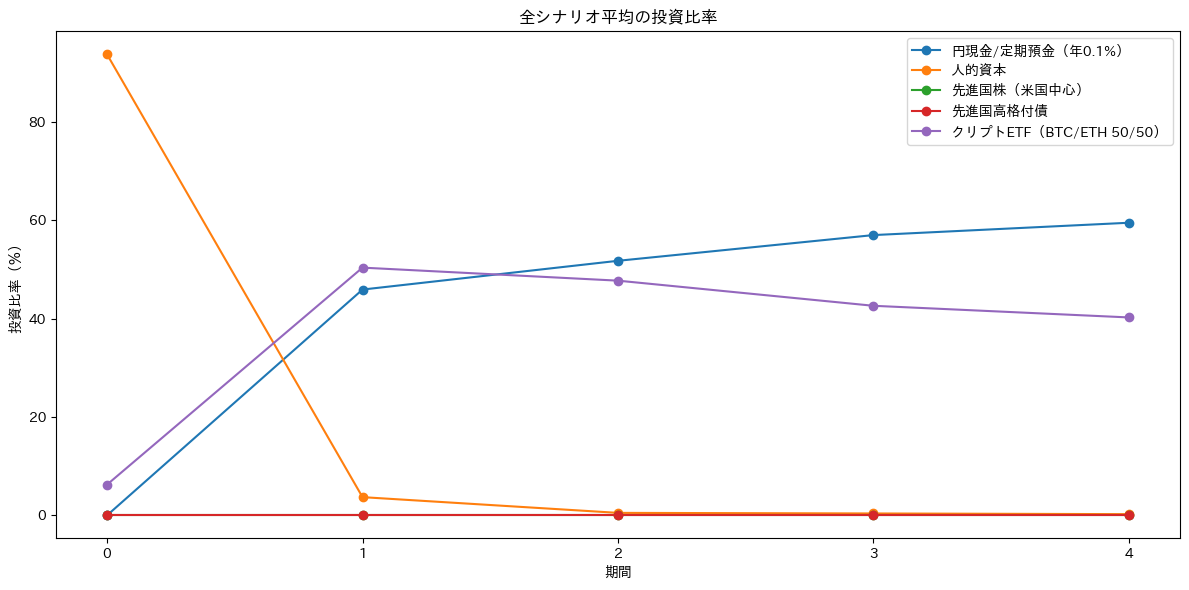

In [22]:
sl.investment_ratio(rho_df, asset_names, sol, v0_val, h0_val, v_val, h_val, z_val, SCEN, T, W_0, W_E, W_G)

In [23]:
beta

array([  400.,   600.,   800.,  1000.,  1200.,  2000.,  5000., 10000.])

全シナリオ平均の資産構成 (初期富：100.0, 目標富：8000.0, 期待富：20000.0)


,富,円現金/定期預金（年0.1%）,賃金,先進国株（米国中心）,先進国高格付債,クリプトETF（BTC/ETH 50/50）
t,,,,,,
1,2006.49,0.00,2000.0,0.0,0.0,6.49
2,12090.11,946.10,10000.0,0.0,0.0,1144.01
3,22141.28,6451.54,10000.0,0.0,0.0,5689.74
4,33436.26,12909.36,10000.0,0.0,0.0,10526.90
5,43855.55,20272.78,10000.0,0.0,0.0,13582.78


<Axes: xlabel='t'>

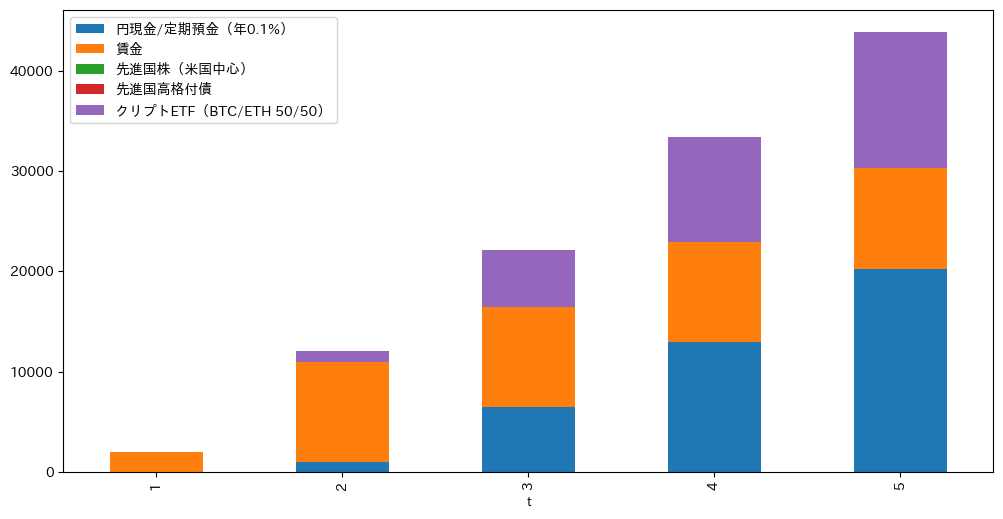

In [24]:
sl.asset_composition(sol, rho_df, r_df, asset_names, v0_val, v_val, z_val, y_val, initial_call_rate, SCEN, TIME, W_0, W_E, W_G)

Segment counts by period:


k,6,8
t,,
1,100,0
2,0,100
3,0,100
4,0,100
5,0,100


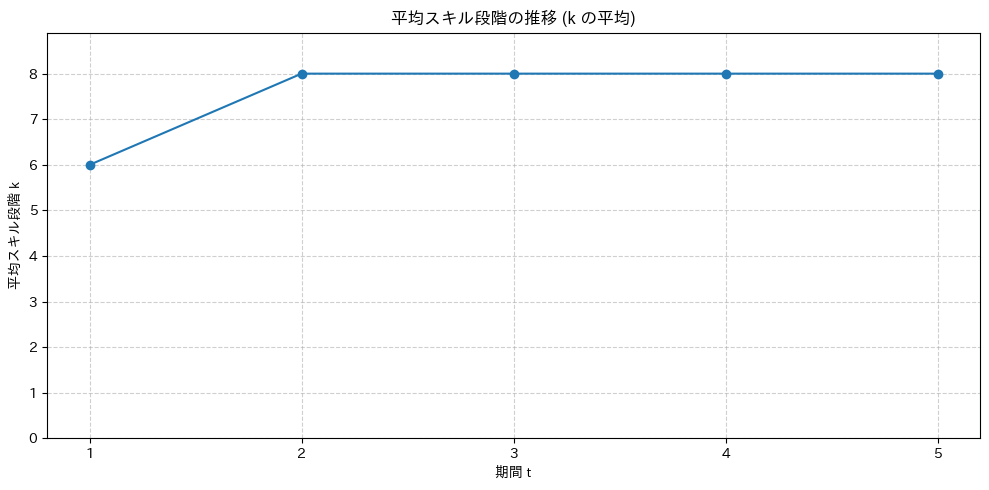

In [25]:
sl.show_skill_chg(sol)